In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [2]:
# add a chatbot node

from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [3]:
# add an entry point
graph_builder.add_edge(START, "chatbot")

In [4]:
# set a finish point
graph_builder.add_edge("chatbot", END)

In [5]:
# call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.
graph = graph_builder.compile()

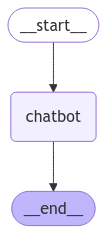

In [7]:
# visualize the graph using the get_graph method

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
# now let's run the chatbot

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I assist you today?
Assistant: Hello! How can I assist you today?
Assistant: Hello! How can I assist you today?
Assistant: It seems like your message might be incomplete or unclear. Could you please provide more context or clarify what you mean by "uoh"? I'm here to help!
Assistant: Hello! I’m an AI language model created by OpenAI, here to assist you with information, answer your questions, or just chat. How can I help you today?
Assistant: My knowledge was cut off in October 2021. I don't have information on events or developments that occurred after that date.
Assistant: As of my last knowledge update in October 2023, "LangGraph" might refer to various concepts or projects, but it does not appear to be a widely recognized term or product. It's possible that it could relate to language processing, graph data structures, or a specific tool or library designed for working with language data in the form of graphs. 

If "LangGraph" is a recent development, produ

In [9]:
# enhancing the chatbot with tools
load_dotenv()

# define the tool
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What is tool in LangGrapg?")

[{'url': 'https://medium.com/@vivekvjnk/introduction-to-tool-use-with-langgraphs-toolnode-0121f3c8c323',
  'content': 'Introduction to Tool Use with LangGraph’s ToolNode | by Story_Teller | Dec, 2024 | Medium @tool @tool def llm_calculator_tool(inputs): """A simple two-input calculator tool that delegates arithmetic operations to an LLM. {\'description\': "A simple two-input calculator tool that delegates arithmetic operations to an LLM.\\n\\nArg:\\n    inputs: A dictionary with the following keys:\\n            operation (str): The operation to perform (\'add\', \'subtract\', \'multiply\', \'divide\').\\n            num1 (float): The first number.\\n            num2 (float): The second number.\\n\\nReturns:\\n    dict: A dictionary containing the operation, inputs, and the result.", Here we explores how to enable tool use with LLM calls, emphasizing model selection, tool binding, and the importance of guiding tool behavior. This equips the LLM with the ability to perform tool calls se

In [10]:
# defining the graph, added bind_tools on our LLM
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")
# modification -> tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [11]:
# create a function to actually run the tools if they are called
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
    
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name = tool_call["name"],
                    tool_call_id = tool_call["id"]
                )
            )
        return {"messages": outputs}
    
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)